# Brain Tumor Detection on MRI Dataset

Link to brain tumor dataset: https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection

In dataset we have two folders:
1. Folder named "yes" with brain tumor pictures
2. Folder named "no" with no brain tumor pictures

What is the goal?
To detect and classify brain tumor using CNN.

# Import packages

In [115]:
import tensorflow as tf
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow import keras
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import layers, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import EfficientNetB0
from keras.backend import clear_session

import warnings
warnings.filterwarnings('ignore')

In [96]:
print("Eager execution:", tf.executing_eagerly())

Eager execution: True


## Reading the images

In [3]:
tumor = []
tumor_labels = []

path = './data/brain_tumor_dataset/yes/*.jpg'
for f in glob.iglob(path):
    img = cv2.imread(f)
    if img is None:
        print(f"Problem with loading: {f}")
        continue
    img = cv2.resize(img, (128, 128))
    b, g, r = cv2.split(img)
    img = cv2.merge([r, g, b])
    tumor.append(img)
    tumor_labels.append(1)

In [4]:
healthy = []
healthy_labels = []

path = './data/brain_tumor_dataset/no/*.jpg'
for f in glob.iglob(path):
    img = cv2.imread(f)
    if img is None:
        print(f"Problem with loading: {f}")
        continue
    img = cv2.resize(img, (128, 128))
    b, g, r = cv2.split(img)
    img = cv2.merge([r, g, b])
    healthy.append(img)
    healthy_labels.append(0)

In [5]:
print("Healthy count:", len(healthy))
print("Tumor count:", len(tumor))

Healthy count: 91
Tumor count: 154


In [6]:
healthy = np.array(healthy)
tumor = np.array(tumor)
healthy_labels = np.array(healthy_labels)
tumor_labels = np.array(tumor_labels)

In [7]:
data = np.concatenate((healthy, tumor), axis=0)
labels = np.concatenate((healthy_labels, tumor_labels), axis=0)

# Visualizing Brain MRI Images

In [8]:
def plot_random(healthy, tumor, num=5):
    healthy_imgs = healthy[np.random.choice(healthy.shape[0], num, replace=False)]
    tumor_imgs = tumor[np.random.choice(tumor.shape[0], num, replace=False)]

    plt.figure(figsize=(16,9))
    for i in range(num):
        plt.subplot(1, num, i+1)
        plt.title('Healthy')
        plt.imshow(healthy_imgs[i])


    plt.figure(figsize=(16,9))
    for i in range(num):
        plt.subplot(1, num, i+1)
        plt.title('Tumor')
        plt.imshow(tumor_imgs[i])

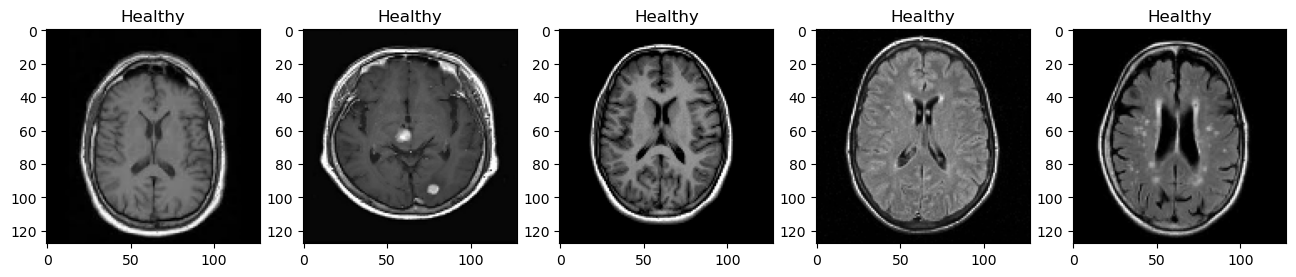

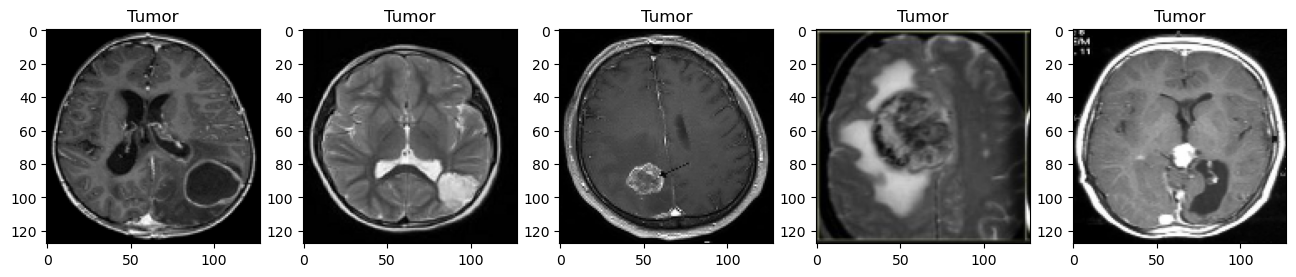

In [9]:
plot_random(healthy, tumor)

# Data Scaling and Split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42, shuffle=True)

In [11]:
#normalize the pixel value

X_train = X_train / 255.0
X_test = X_test / 255.0

In [12]:
print(X_train.shape, y_train.shape)

(196, 128, 128, 3) (196,)


In [13]:
y_train = y_train.reshape(-1, 1) 

In [14]:
print(X_test.shape, y_test.shape)

(49, 128, 128, 3) (49,)


In [15]:
y_test = y_test.reshape(-1, 1) 

In [16]:
print(X_test.shape, y_test.shape)

(49, 128, 128, 3) (49, 1)


In [17]:
print(X_train.shape, y_train.shape)

(196, 128, 128, 3) (196, 1)


In [18]:
print ("number of test examples = " + str(X_test.shape[0]))
print ("number of training examples = " + str(X_train.shape[0]))

number of test examples = 49
number of training examples = 196


In [19]:
#just in case checking the data

print("Max value in scaled data:", X_train.max())
print("Min value in scaled data:", X_train.min())

Max value in scaled data: 1.0
Min value in scaled data: 0.0


# Building First Model

In [20]:
model_1 = Sequential()

model_1.add(Conv2D(16, kernel_size=(3,3), activation='relu', input_shape=(128, 128, 3)))
model_1.add(MaxPooling2D(2,2))
model_1.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
model_1.add(MaxPooling2D(2,2))
model_1.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model_1.add(MaxPooling2D(2,2))
model_1.add(Flatten())
model_1.add(Dropout(0.50))
model_1.add(Dense(128, activation='relu'))
model_1.add(Dropout(0.50))
model_1.add(Dense(1, activation='sigmoid'))

In [21]:
ES = EarlyStopping(patience=10, monitor="val_accuracy")

model_1.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])

In [22]:
model_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,605,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,629,473 (6.22 MB)

 Trainable params: 1,629,473 (6.22 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
history_model_1 = model_1.fit(X_train,
                              y_train,
                              epochs=50,
                              batch_size=16,
                              validation_split=0.2,
                              callbacks=[ES])

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 0.6218 - loss: 0.6790 - val_accuracy: 0.7500 - val_loss: 0.5604
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.8156 - loss: 0.4482 - val_accuracy: 0.7000 - val_loss: 0.6555
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 0.7851 - loss: 0.4854 - val_accuracy: 0.7750 - val_loss: 0.5563
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.8350 - loss: 0.4134 - val_accuracy: 0.8000 - val_loss: 0.5863
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.7998 - loss: 0.4725 - val_accuracy: 0.8000 - val_loss: 0.5468
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 0.7922 - loss: 0.4283 - val_accuracy: 0.8000 - val_loss: 0.5775
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.8397 - loss: 0.3727 - val_accuracy: 0.7750 - val_loss: 0.5328
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.8351 - loss: 0.3756 - val_accuracy: 0.7750 - 

In [24]:
test_loss, test_accuracy = model_1.evaluate(X_test, y_test)
print("test loss", test_loss)
print("test accuracy", test_accuracy)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.8182 - loss: 0.7642
test loss 0.6730902791023254
test accuracy 0.8367347121238708


In [25]:
model_1.save("model_1.keras")

## Confusion Matrix and Classification Report

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


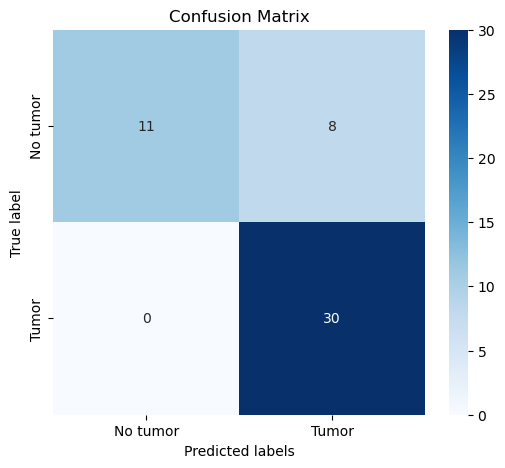

Classification report:
               precision    recall  f1-score   support

    No tumor       1.00      0.58      0.73        19
       Tumor       0.79      1.00      0.88        30

    accuracy                           0.84        49
   macro avg       0.89      0.79      0.81        49
weighted avg       0.87      0.84      0.82        49



In [26]:
y_pred_prob = model_1.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["No tumor", "Tumor"], yticklabels=["No tumor", "Tumor"])
plt.xlabel("Predicted labels")
plt.ylabel("True label")
plt.title("Confusion Matrix")
plt.show()

print("Classification report:\n", classification_report(y_test, y_pred, target_names=["No tumor", "Tumor"]))

#### Model_1 deals with "No tumor" worse. There are misclassifications where "No tumor" is classified as "Tumor". Good point is that most "Tumor" are classified right but still this is not enough and can be very dangerous for sick patients who can be diagnosed as "No tumor" and those who are healthy and are diagnosed with tumor.

## Accuracy and loss plot

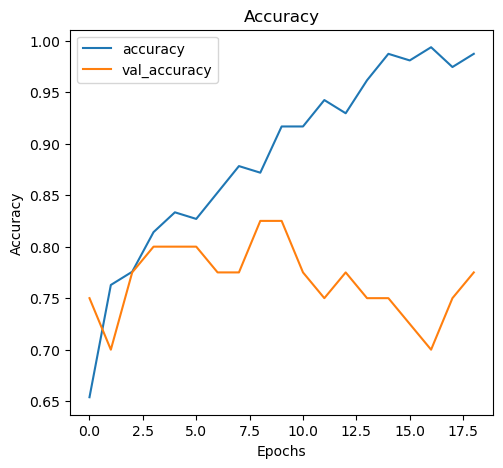

In [27]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_model_1.history["accuracy"], label="accuracy")
plt.plot(history_model_1.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.legend()
plt.show()

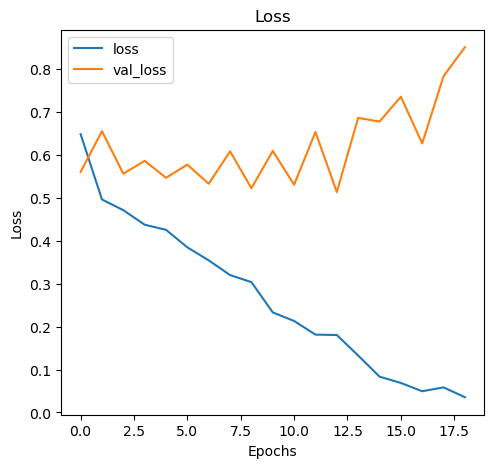

In [28]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_model_1.history["loss"], label="loss")
plt.plot(history_model_1.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss")
plt.legend()
plt.show()

#### The further the epoch, the greater the difference between the training and validation sets, which is a sign of overfitting. Val_loss starts increasing after a few epochs which means the model start memorizing train data instead of generalizing. There is also disadvantage of data randomness because one time test set accuracy is 70 but in subsequent attempts is 81 and even more. I have to reduce overfitting and improve generalization in next model.

# Building Second Model

In [29]:
#i am going to use padding to prevent the data dimension from becoming too small
#the more convolution layers or more pooling layers, it would seem that my model will have better accuracy due to the greater number of parameters.
#i will use Dropout=0.3 and batch_size=32

model_2 = Sequential()

model_2.add(Conv2D(16, kernel_size=(3,3), activation='relu', padding='same', input_shape=(128, 128, 3)))
model_2.add(Conv2D(16, kernel_size=(3,3), activation='relu', padding='same'))
model_2.add(MaxPooling2D(2,2))

model_2.add(Conv2D(32, kernel_size=(3,3), activation='relu', padding='same'))
model_2.add(Conv2D(32, kernel_size=(3,3), activation='relu', padding='same'))
model_2.add(MaxPooling2D(2,2))

model_2.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
model_2.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
model_2.add(MaxPooling2D(2,2))

model_2.add(Conv2D(128, kernel_size=(3,3), activation='relu', padding='same'))
model_2.add(Conv2D(128, kernel_size=(3,3), activation='relu', padding='same'))
model_2.add(MaxPooling2D(2,2))

model_2.add(Flatten())
model_2.add(Dropout(0.3))
model_2.add(Dense(256, activation='relu'))
model_2.add(Dropout(0.3))
model_2.add(Dense(128, activation='relu'))
model_2.add(Dense(1, activation='sigmoid'))

In [30]:
ES2 = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model_2.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])

In [31]:
model_2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 128, 128, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 128, 128, 16)        │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 64, 64, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 64, 64, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 64, 64, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │       2,097,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,423,953 (9.25 MB)

 Trainable params: 2,423,953 (9.25 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
history_model_2 = model_2.fit(X_train,
                              y_train,
                              epochs=50,
                              batch_size=32,
                              validation_split=0.2,
                              callbacks=[ES2])

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 579ms/step - accuracy: 0.5405 - loss: 0.7647 - val_accuracy: 0.6750 - val_loss: 0.6845
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 422ms/step - accuracy: 0.6009 - loss: 0.6876 - val_accuracy: 0.6750 - val_loss: 0.6849
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 492ms/step - accuracy: 0.6187 - loss: 0.6833 - val_accuracy: 0.6750 - val_loss: 0.6516
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 523ms/step - accuracy: 0.6322 - loss: 0.6608 - val_accuracy: 0.6750 - val_loss: 0.6168
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 559ms/step - accuracy: 0.5875 - loss: 0.6776 - val_accuracy: 0.6750 - val_loss: 0.6363
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 520ms/step - accuracy: 0.6196 - loss: 0.6265 - val_accuracy: 0.6750 - val_loss: 0.5926
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 478ms/step - accuracy: 0.7092 - loss: 0.5461 - val_accuracy: 0.7000 - val_loss: 0.6142
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 478ms/step - accuracy: 0.7344 - loss: 0.5636 - val_accuracy: 0.7250 - val_loss:

In [33]:
test_loss, test_accuracy = model_2.evaluate(X_test, y_test)
print("test loss", test_loss)
print("test accuracy", test_accuracy)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.7326 - loss: 0.6163
test loss 0.584342896938324
test accuracy 0.7551020383834839


In [34]:
model_2.save("model_2.keras")

## Confusion Matrix and Classification Report

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 245ms/step


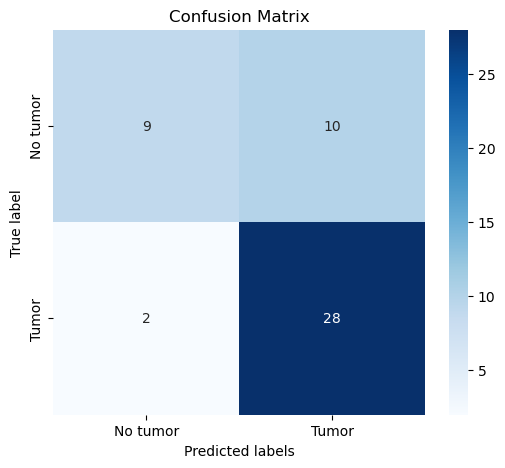

Classification report:
               precision    recall  f1-score   support

    No tumor       0.82      0.47      0.60        19
       Tumor       0.74      0.93      0.82        30

    accuracy                           0.76        49
   macro avg       0.78      0.70      0.71        49
weighted avg       0.77      0.76      0.74        49



In [35]:
y_pred_prob = model_2.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["No tumor", "Tumor"], yticklabels=["No tumor", "Tumor"])
plt.xlabel("Predicted labels")
plt.ylabel("True label")
plt.title("Confusion Matrix")
plt.show()

print("Classification report:\n", classification_report(y_test, y_pred, target_names=["No tumor", "Tumor"]))

## Accuracy and loss plot

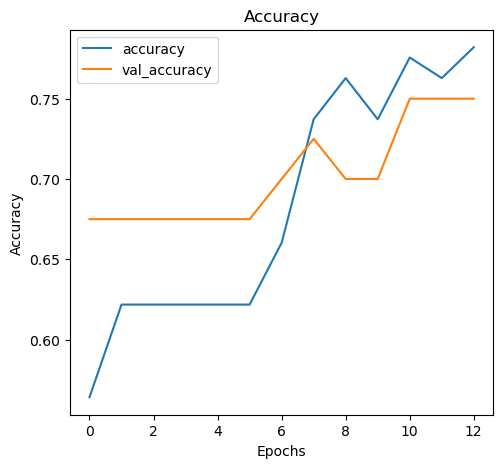

In [36]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_model_2.history["accuracy"], label="accuracy")
plt.plot(history_model_2.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.legend()
plt.show()

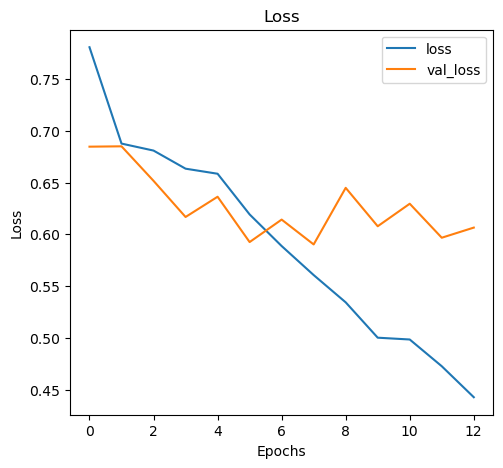

In [37]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_model_2.history["loss"], label="loss")
plt.plot(history_model_2.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss")
plt.legend()
plt.show()

#### Still i can see typical overfitting. Accuracy increases but val_accuracy fluctuates so the model learns well on training set but does not generalize well on test set. Loss decreases but val_loss starts to increase from epoch 20 so the model start to memorize the training data instead of learning general patterns. I will try with data augmentation in the next model. 

# Building Third Model

In [38]:
#i am going to use ImageDataGenerator for better generalization
#previous validation_split does not work with datagen.flow() so i have to do it once again

X_train_new, X_val, y_train_new, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest' #fill pixels after transformation
)

datagen.fit(X_train)

In [39]:
#i can see that the more parameters and layers does not guarantee good efects. I will reduce the number of layers and neurons.
#i will try also with L2 regularization in Dense layer - to prevent learning too complicated patterns.
#i will add smaller learning_rate to prevent the model from overfitting quickly and allows for better adjustment of the weights.
#i will increase Dropout to 0.5 - the model will not overly rely on individual neurons.

model_3 = Sequential()

model_3.add(Conv2D(32, kernel_size=(3,3), activation='relu', padding='same'))  
model_3.add(Conv2D(32, kernel_size=(3,3), activation='relu', padding='same'))  
model_3.add(MaxPooling2D(2,2))  

model_3.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))  
model_3.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))  
model_3.add(MaxPooling2D(2,2))

model_3.add(Flatten())
model_3.add(Dropout(0.5))
model_3.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))
model_3.add(Dropout(0.5))
model_3.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
model_3.add(Dense(1, activation='sigmoid'))

In [40]:
optimizer = Adam(learning_rate=0.0001)

model_3.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])

In [41]:
history_model_3 = model_3.fit(
    datagen.flow(X_train_new, y_train_new, batch_size=32),
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks=[ES2]
)

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.5836 - loss: 1.3484 - val_accuracy: 0.6750 - val_loss: 1.2305
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.6042 - loss: 1.3010 - val_accuracy: 0.6750 - val_loss: 1.1831
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.6355 - loss: 1.2551 - val_accuracy: 0.6750 - val_loss: 1.1537
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.6347 - loss: 1.2103 - val_accuracy: 0.6750 - val_loss: 1.1272
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.6147 - loss: 1.2064 - val_accuracy: 0.6750 - val_loss: 1.0880
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.5953 - loss: 1.1990 - val_accuracy: 0.7000 - val_loss: 1.0548
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.6115 - loss: 1.1748 - val_accuracy: 0.7250 - val_loss: 1.0238
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.6195 - loss: 1.1300 - val_accuracy: 0.7250 - val_loss: 0.9949
Epoch 9/50
5/5 

In [42]:
test_loss, test_accuracy = model_3.evaluate(X_test, y_test)
print("test loss", test_loss)
print("test accuracy", test_accuracy)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.7294 - loss: 0.8208
test loss 0.7895699143409729
test accuracy 0.7346938848495483


In [43]:
model_3.save("model_3.keras")

## Confusion Matrix and Classification Report

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


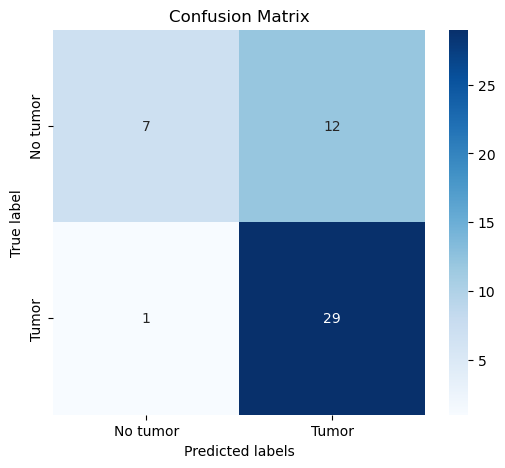

Classification report:
               precision    recall  f1-score   support

    No tumor       0.88      0.37      0.52        19
       Tumor       0.71      0.97      0.82        30

    accuracy                           0.73        49
   macro avg       0.79      0.67      0.67        49
weighted avg       0.77      0.73      0.70        49



In [45]:
y_pred_prob = model_3.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["No tumor", "Tumor"], yticklabels=["No tumor", "Tumor"])
plt.xlabel("Predicted labels")
plt.ylabel("True label")
plt.title("Confusion Matrix")
plt.show()

print("Classification report:\n", classification_report(y_test, y_pred, target_names=["No tumor", "Tumor"]))

## Accuracy and loss plot

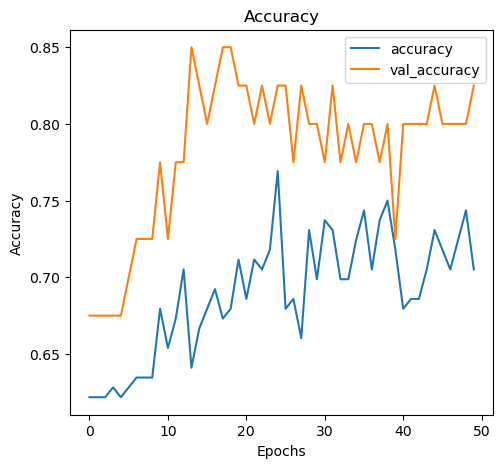

In [46]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_model_3.history["accuracy"], label="accuracy")
plt.plot(history_model_3.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.legend()
plt.show()

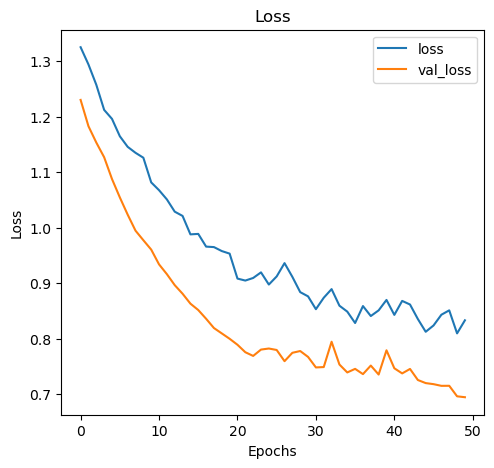

In [47]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_model_3.history["loss"], label="loss")
plt.plot(history_model_3.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss")
plt.legend()
plt.show()

#### Model is very good at detecting tumors but struggles with non tumor cases. This could indicate that "tumor" images are more distinct and easier to learn. The model is overly sensitive to features that it associates with tumors. Maybe augmentation has altered non-tumor images too much making them look abnormal? Maybe model focuses too much on certain patterns present in tumor images but not in healthy ones?

#### Regarding accuracy and loss plot - still overfitting, model performs well on train set but generalize poorly.

#### In the next model i will balance the classes and use VGG16.

# Building Fourth Model

In [48]:
X_train_new, X_val, y_train_new, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [49]:
class_weights_values = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train.ravel() #ensure that y_train is 1D
)

#converting class weights to dict(why? i had unhashable type error - it occured because np.unique return an array and enumerate(class_weights)produces tuples
#and this connot be used as dictionary keys directly

class_weights = {cls: weight for cls, weight in zip(np.unique(y_train), class_weights_values)}
print(class_weights)

{0: 1.3611111111111112, 1: 0.7903225806451613}


In [50]:
#i am going to reduce transformations - avoid too much rotation, zooming, flipping

datagen = ImageDataGenerator(
    rotation_range=10, #lower rotation
    width_shift_range=0.05, #less shift
    height_shift_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True
)

In [51]:
batch = next(iter(datagen.flow(X_train_new, y_train_new, batch_size=32)))
print("Type batch:", type(batch))
print("Type X batch:", type(batch[0]))
print("Type y batch:", type(batch[1]))

Type batch: <class 'tuple'>
Type X batch: <class 'numpy.ndarray'>
Type y batch: <class 'numpy.ndarray'>


In [52]:
#i will use VGG16 transfer learning  - uses pretrained features for better performance

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128,128,3))
base_model.trainable = False

In [53]:
#i had big problem with eager execution error, i thought that there is problem in class weight but the problem was in:
#VGG16 gives Keras Functional model and i tried to place it in Sequential()
#TensorFlow may report an error when in Sequential() is functional model
#the solution was to replace Sequential() with functional model, which is below

In [54]:
inputs = Input(shape=(128,128,3))
x = base_model(inputs, training=False)
x = Flatten()(x)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.4)(x)
outputs = Dense(1, activation='sigmoid')(x)

model_4 = Model(inputs, outputs)

In [55]:
ES2 = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=1e-6)
optimizer = Adam(learning_rate=0.0001)

model_4.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [56]:
history_model_4 = model_4.fit(
    datagen.flow(X_train_new, y_train_new, batch_size=32),        # Augmented training data
    validation_data=(X_val, y_val),     # Validation data without augmentation
    epochs=50,
    class_weight = class_weights,
    callbacks=[ES2, reduce_lr]
)

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 4s/step - accuracy: 0.4996 - loss: 3.3634 - val_accuracy: 0.6250 - val_loss: 3.0678 - learning_rate: 1.0000e-04
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.5528 - loss: 3.1491 - val_accuracy: 0.7750 - val_loss: 2.8903 - learning_rate: 1.0000e-04
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.6370 - loss: 2.9901 - val_accuracy: 0.8500 - val_loss: 2.7951 - learning_rate: 1.0000e-04
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 18s 4s/step - accuracy: 0.6748 - loss: 2.8458 - val_accuracy: 0.7250 - val_loss: 2.7590 - learning_rate: 1.0000e-04
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 24s 5s/step - accuracy: 0.6396 - loss: 2.8127 - val_accuracy: 0.8750 - val_loss: 2.6079 - learning_rate: 1.0000e-04
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - accuracy: 0.7173 - loss: 2.6436 - val_accuracy: 0.9000 - val_loss: 2.5086 - learning_rate: 1.0000e-04
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 19s 4s/step - accuracy: 0.6982 - loss: 2.6106 - val_

In [57]:
test_loss, test_accuracy = model_4.evaluate(X_test, y_test)
print("test loss", test_loss)
print("test accuracy", test_accuracy)

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.8799 - loss: 1.0773
test loss 1.0472248792648315
test accuracy 0.8979591727256775


In [110]:
model_4.save("model_4.keras")

## Confusion Matrix and Classification Report

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step


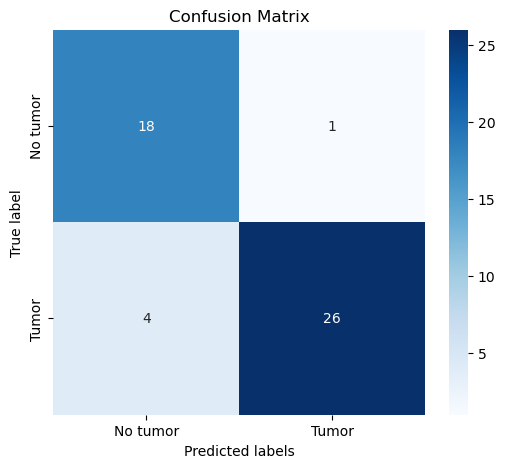

Classification report:
               precision    recall  f1-score   support

    No tumor       0.82      0.95      0.88        19
       Tumor       0.96      0.87      0.91        30

    accuracy                           0.90        49
   macro avg       0.89      0.91      0.90        49
weighted avg       0.91      0.90      0.90        49



In [58]:
y_pred_prob = model_4.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["No tumor", "Tumor"], yticklabels=["No tumor", "Tumor"])
plt.xlabel("Predicted labels")
plt.ylabel("True label")
plt.title("Confusion Matrix")
plt.show()

print("Classification report:\n", classification_report(y_test, y_pred, target_names=["No tumor", "Tumor"]))

## Accuracy and loss plot

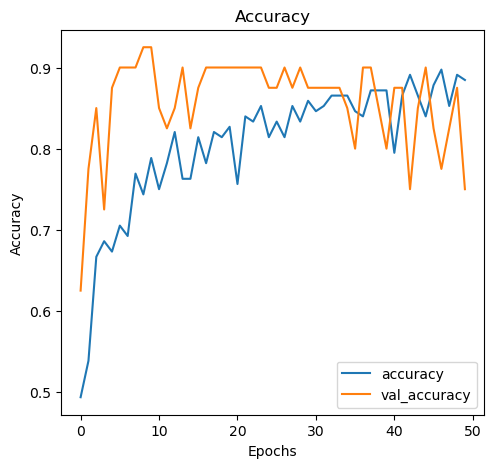

In [59]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_model_4.history["accuracy"], label="accuracy")
plt.plot(history_model_4.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.legend()
plt.show()

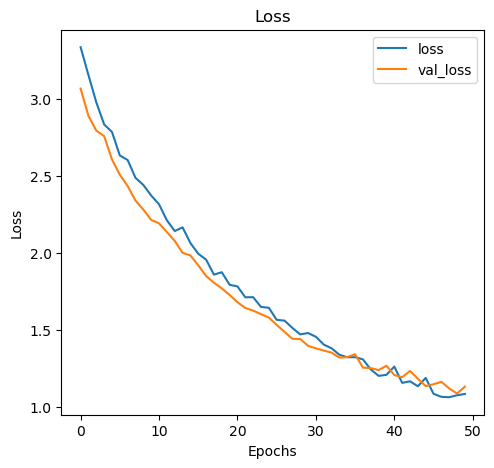

In [60]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_model_4.history["loss"], label="loss")
plt.plot(history_model_4.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss")
plt.legend()
plt.show()

#### No tumor class - the model has right in 82% cases where there is no tumor. Recall is high 95%. F1 score 88% means quite good balance between precision and recall. 

#### Tumor class - precision is much higher than in no tumor. Recall is good because detects 87% cases with tumor. F1 score 91% is perfect.

#### Summary: The model is very good in detecting tumor, worse is in detecting no tumor. Class balance is good but maybe the model focuses too much on detecting tumors. Accuracy 90% is good but not perfect. The model still needs improvements. 

#### Accuracy plot: results are much better than in previous models.

#### Loss plot: Both curves show a smooth decline, indicating that the model is learning effectively and not overfitting (since validation loss is not increasing)

#### So far this is the best model.